In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
fname1 = "electron_30deg_50wob_NOISE120.mscw.fits"
with fits.open(fname1) as hdul:
   df1 = Table.read(hdul[1]).to_pandas()

fname2 = "protons_30deg_5.0wob_NOISE120.mscw.fits"
with fits.open(fname2) as hdul:
   df2 = Table.read(hdul[1]).to_pandas()

# fname3 = "helium_30deg_5.0wob_NOISE120.mscw.fits"
# with fits.open(fname3) as hdul:
#    df3 = Table.read(hdul[1]).to_pandas()

In [6]:
electron = df1.copy()
gamma = electron.iloc[:,:]  # electron and gamma shower identical after first interaction
proton = df2.copy()
hadron = proton.iloc[:,:]  # proton is hadron
#gamma.info()

In [7]:
gamma['class'] = 1  # postive class
hadron['class'] = 0  # negative class

In [8]:
gamma.shape

(466422, 60)

In [9]:
hadron = hadron.iloc[:466422,:]  # to obtain 1:1 ratio
hadron.shape

(466422, 60)

In [10]:
particles = pd.concat([gamma, hadron], ignore_index=True)  # combining datasets
particles.shape

(932844, 60)

In [28]:
X = particles[['MSCW', 'MSCL', 'EChi2S', 'EmissionHeight', 
               'EmissionHeightChi2', 'SizeSecondMax', 'Core']]
y = particles['class']

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape

(559706, 7)

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# create model
model = Sequential()
model.add(Flatten(input_shape =(X_train.shape[1],1)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [41]:
# Reshape the input data to fit the CNN (assuming one channel)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# Train the model and track the training history
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=30, shuffle=True,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/20
18657/18657 [==============================] - 28s 1ms/step - loss: 0.3365 - accuracy: 0.8601 - val_loss: 0.3182 - val_accuracy: 0.8679
Epoch 2/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3188 - accuracy: 0.8673 - val_loss: 0.3150 - val_accuracy: 0.8683
Epoch 3/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3158 - accuracy: 0.8683 - val_loss: 0.3116 - val_accuracy: 0.8699
Epoch 4/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3142 - accuracy: 0.8688 - val_loss: 0.3112 - val_accuracy: 0.8697
Epoch 5/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3130 - accuracy: 0.8693 - val_loss: 0.3102 - val_accuracy: 0.8704
Epoch 6/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3123 - accuracy: 0.8693 - val_loss: 0.3103 - val_accuracy: 0.8700
Epoch 7/20
18657/18657 [==============================] - 27s 1ms/step - loss: 0.3116 - accuracy: 0.8698 - val_loss: 0

In [43]:
from sklearn.metrics import roc_curve, auc
# import pickle

In [44]:
# model_path = 'NN_train.sav'

# with open(model_path, 'rb') as model_file:
#     model = pickle.load(model_file)

In [45]:
# Get the predicted probabilities for the test set
y_pred = model.predict(X_test_reshaped)

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

11661/11661 [==============================] - 8s 656us/step
ROC AUC: 0.9429193165706973


11661/11661 [==============================] - 8s 655us/step


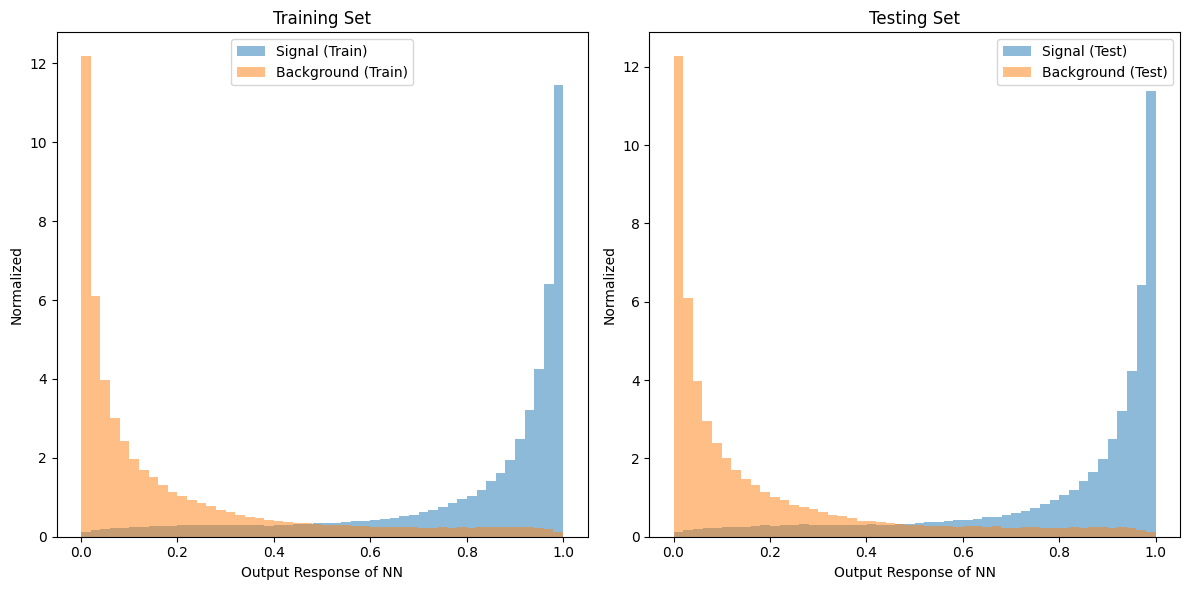

In [46]:
train_signal_probs = model.predict(X_train_reshaped)
test_signal_probs = model.predict(X_test_reshaped)

plt.figure(figsize=(12, 6))

# Plot histograms for signal and background in training set
plt.subplot(1, 2, 1)
plt.hist(train_signal_probs[y_train == 1], bins=50, alpha=0.5, label='Signal (Train)', density = True)
plt.hist(train_signal_probs[y_train == 0], bins=50, alpha=0.5, label='Background (Train)', density = True)
plt.xlabel('Output Response of NN')
plt.ylabel('Normalized')
plt.title('Training Set')
plt.legend()

# Plot histograms for signal and background in testing set
plt.subplot(1, 2, 2)
plt.hist(test_signal_probs[y_test == 1], bins=50, alpha=0.5, label='Signal (Test)', density = True)
plt.hist(test_signal_probs[y_test == 0], bins=50, alpha=0.5, label='Background (Test)', density = True)
plt.xlabel('Output Response of NN')
plt.ylabel('Normalized')
plt.title('Testing Set')
plt.legend()

plt.tight_layout()
plt.savefig('output_NN')
plt.show()

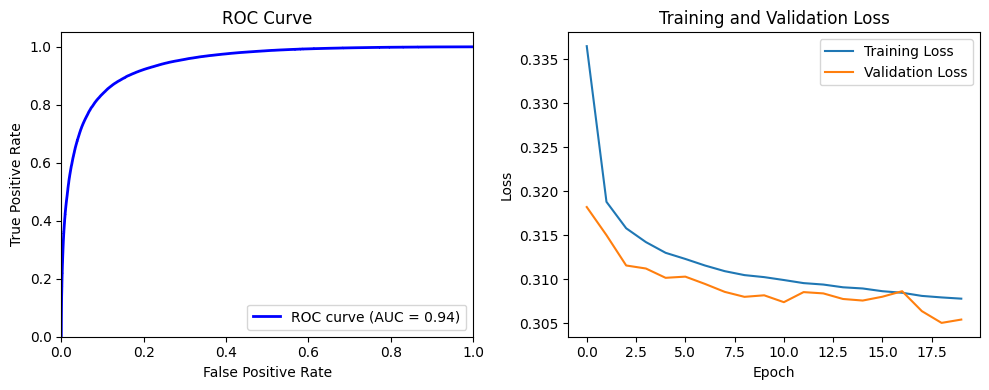

In [47]:
# ROC curve
plt.figure(figsize = (10,4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig('NN_ROC_loss')
plt.show()

In [33]:
import pickle
filename = 'NN_train.sav'
pickle.dump(model, open(filename, 'wb'))